In [4]:
from langgraph.graph import StateGraph,START,MessagesState,END
from typing import TypedDict, Literal, Optional

# Define the workflow state class
class WorkflowState(TypedDict):
    phase: Literal[
        "Requirements", "User Stories", "Design", "Development", 
        "Code Review", "Security Review", "Testing", "Deployment", 
        "Monitoring", "Maintenance"
    ]
    approval_status: Literal["Pending", "Approved", "Needs Revision"]
    feedback: Optional[str]
    code_status: Literal["Not Started", "In Progress", "Completed"]
    test_status: Literal["Not Started", "In Progress", "Completed"]
    deployment_status: Literal["Not Started", "In Progress", "Completed"]
    monitoring_status: Literal["Not Started", "In Progress", "Completed"]

# Initialize the LangGraph workflow
graph = StateGraph(WorkflowState)

def generate_user_stories(MessagesState):
    ...

def product_owner_review(MessagesState):
    ...

def create_design_document(MessagesState):
    ...


def revise_user_stories(MessagesState):
    ...

def product_owner_status(MessagesState):
    return "Approved"

def design_review(MessagesState):
    ...

def validate_design_review(MessagesState):
    return "Approved"

def generate_code(MessagesState):
    return "Approved"


graph.add_node("user_stories",generate_user_stories)
graph.add_node("owner_review",product_owner_review)
graph.add_node("new_design_document",create_design_document)
graph.add_node("revise_stories",revise_user_stories)
graph.add_node("review_design",design_review)
graph.add_node("code_generation",generate_code)


graph.add_edge(START,"user_stories")
graph.add_edge("user_stories","owner_review")
graph.add_conditional_edges("owner_review",product_owner_status,{"Approved":"new_design_document","Feedback":"revise_stories"})
graph.add_edge("new_design_document","review_design")
graph.add_edge("revise_stories","user_stories")
graph.add_conditional_edges("review_design",validate_design_review,{"Approved":"code_generation","Feedback":"new_design_document"})
graph.add_edge("code_generation",END)

graph.compile()






ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [1]:
from langchain_openai import ChatOpenAI
import openai
from docx import Document

# Set up OpenAI API key
openai.api_key = ''  # Use your OpenAI API key here
combined_spec_prompt = """
You are an AI that generates a comprehensive software system specification document. Based on the following user stories, create a single document that includes both functional and design specifications.

### User Stories
{user_stories}

### Functional Specification

Based on the above user stories, generate a functional specification document that includes:
1. Functional Requirements
2. Non-Functional Requirements
3. Constraints
4. Stakeholders

### Design Specification

Based on the system functionality described above, generate a design specification document that includes:
1. Architecture Overview
2. Data Model
3. Components and their Interactions
4. API Contracts
5. Security Considerations

Please structure the document as follows:
1. Overview
2. Functional Specifications
3. Non-Functional Specifications
4. Constraints
5. Stakeholders
6. Architecture Overview
7. Data Model
8. Components and Interactions
9. API Contracts
10. Security Considerations
"""


# Function to generate the comprehensive document (functional and design)
def generate_comprehensive_spec(user_stories):
    # Format the combined prompt
    prompt = combined_spec_prompt.format(
        user_stories="\n".join([f"- {story}" for story in user_stories])
    )

    # # Call the OpenAI API to generate the document
    # response = openai.Completion.create(
    #     model="text-davinci-003",  # Or use "gpt-4" if you have access
    #     prompt=prompt,
    #     max_tokens=3000,
    #     temperature=0.7
    # )
    llm = ChatOpenAI(model="text-davinci-003",stream_usage=True,api_key="")
    response = llm.invoke(prompt)
    # Return the generated text (the document content)
    return response.choices[0].text.strip()


# Example User Stories
user_stories = [
    "As a user, I want to register with my email and password so that I can create an account.",
    "As a user, I want to log in using my email and password so that I can access my account.",
    "As an admin, I want to view a list of registered users so that I can manage accounts."
]

# Generate the comprehensive specification document
comprehensive_spec = generate_comprehensive_spec(user_stories)

print("Comprehensive Specification Document:\n", comprehensive_spec)

# Save the document to a DOCX file
doc = Document()
doc.add_heading('Comprehensive Specification Document for User Registration and Login', 0)

# Add the generated content to the Word document
doc.add_paragraph(comprehensive_spec)

# Save the DOCX document
doc.save('comprehensive_specification.docx')

print("Comprehensive specification document saved successfully!")


NotFoundError: Error code: 404 - {'error': {'message': 'The model `text-davinci-003` has been deprecated, learn more here: https://platform.openai.com/docs/deprecations', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In [ ]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return f"I looked up: {query}. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈."


tools = [search]
tool_node = ToolNode(tools)

# Set up the model


model = ChatOpenAI(model="gpt-4o",stream_usage=True,api_key="")

from pydantic import BaseModel


# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])

# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    location = input("Please provide your location:")
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}


# Build the graph

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory)

#display(Image(app.get_graph().draw_mermaid_png()))

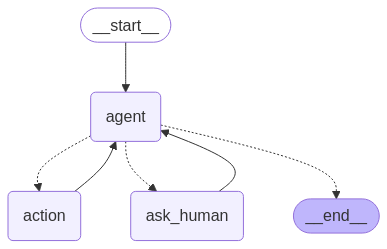

In [12]:
app

In [20]:
config = {"configurable": {"thread_id": "2"}}
for event in app.stream(
    {
        "messages": [
            (
                "user",
                "Use the search tool to ask the user where they are, then look up the weather there",
            )
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Use the search tool to ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_P4InR1rz0Y9hu1iC46hKIkaM)
 Call ID: call_P4InR1rz0Y9hu1iC46hKIkaM
  Args:
    question: Could you please provide a specific city or region in India for a more accurate weather update?
================================= Tool Message =================================

Bangalore
================================== Ai Message ==================================
Tool Calls:
  search (call_Gx7jLEWnYaIqFnXVXf2qHG8f)
 Call ID: call_Gx7jLEWnYaIqFnXVXf2qHG8f
  Args:
    query: current weather in Bangalore
================================= Tool Message =================================
Name: search

I looked up: current weather in Bangalore. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈.
======

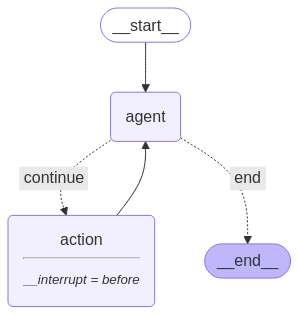

In [ ]:
# Set up the tool
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# Set up the model

model = ChatOpenAI(model="gpt-4o",stream_usage=True,api_key="")
model = model.bind_tools(tools)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

#display(Image(app.get_graph().draw_mermaid_png()))
app

In [26]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="search for the weather in sf now")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

search for the weather in sf now


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_zb1eyn8GZeTkxuvi3CVtxExf", 'type': 'invalid_request_error', 'param': 'messages.[2].role', 'code': None}}

In [ ]:
import langgraph
import threading
from langgraph.graph import StateGraph
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from typing import TypedDict, Literal

# Initialize OpenAI Model
llm = ChatOpenAI(model_name="gpt-4-turbo",api_key="")

# Step 1: Define Workflow State
class ReviewState(TypedDict):
    status: Literal["Pending Review", "Approved", "Rejected", "Needs Human Input"]
    request_data: str

# Step 2: Create StateGraph using langgraph.graph.StateGraph
workflow = StateGraph(ReviewState)

# Step 3: Developer Submits a Request
def submit_request(state: ReviewState) -> ReviewState:
    return {"status": "Pending Review", "request_data": state["request_data"]}

workflow.add_node("submit_request", submit_request)

# Step 4: AI-Based Product Owner Review
def product_owner_review(state: ReviewState) -> ReviewState:
    """Automated AI review"""
    review_prompt = f"Review request: {state['request_data']}. Approve or Reject?"
    response = llm([HumanMessage(content=review_prompt)])

    if "approve" in response.content.lower():
        return {"status": "Approved", "request_data": state["request_data"]}
    elif "reject" in response.content.lower():
        return {"status": "Rejected", "request_data": state["request_data"]}
    else:
        return {"status": "Needs Human Input", "request_data": state["request_data"]}

workflow.add_node("product_owner_review", product_owner_review)

# Step 5: Final Decision Node
def final_decision(state: ReviewState) -> ReviewState:
    """Store the final decision"""
    return {"status": state["status"], "request_data": state["request_data"]}

workflow.add_node("final_decision", final_decision)

# Step 6: Define Workflow Execution Paths
workflow.add_edge("submit_request", "product_owner_review")
workflow.add_edge("product_owner_review", "final_decision")

# Step 7: Human Interrupt Before AI Review
def human_review_interrupt(state: ReviewState) -> ReviewState:
    """Pause execution before AI review for human input."""
    print("\n⏸️ Execution Paused! Human Review Needed.")
    human_decision = input("Enter decision (Approve/Reject/Continue to AI): ").strip().lower()

    if human_decision in ["approve", "reject"]:
        return {"status": human_decision, "request_data": state["request_data"]}  # Skip AI
    else:
        return state  # Continue to AI Review

# Step 8: Compile Workflow with `interrupt_before`
app = workflow.compile(interrupt_before={"product_owner_review": human_review_interrupt})

# Step 9: Execute Streaming with `app.stream()`
print("\n🚀 Streaming Execution Started...\n")

# Run the streaming process in a separate thread
thread = threading.Thread(target=lambda: app.stream(None, thread, stream_mode="values"))
thread.start()

# Process streaming output
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

print("\n✅ Final Decision Reached!")


TypeError: unsupported operand type(s) for +: 'dict' and 'list'

In [ ]:
import langgraph
import threading
from langgraph.graph import StateGraph
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from typing import TypedDict, Literal

# Initialize OpenAI Model
llm = ChatOpenAI(model_name="gpt-4-turbo",api_key="")

# Step 1: Define Workflow State
class ReviewState(TypedDict):
    status: Literal["Pending Review", "Approved", "Rejected", "Needs Human Input"]
    request_data: str

# Step 2: Create StateGraph using langgraph.graph.StateGraph
workflow = StateGraph(ReviewState)

# Step 3: Developer Submits a Request
def submit_request(state: ReviewState) -> ReviewState:
    return {"status": "Pending Review", "request_data": state["request_data"]}

workflow.add_node("submit_request", submit_request)

# Step 4: AI-Based Product Owner Review
def product_owner_review(state: ReviewState) -> ReviewState:
    """Automated AI review"""
    review_prompt = f"Review request: {state['request_data']}. Approve or Reject?"
    response = llm([HumanMessage(content=review_prompt)])

    if "approve" in response.content.lower():
        return {"status": "Approved", "request_data": state["request_data"]}
    elif "reject" in response.content.lower():
        return {"status": "Rejected", "request_data": state["request_data"]}
    else:
        return {"status": "Needs Human Input", "request_data": state["request_data"]}

workflow.add_node("product_owner_review", product_owner_review)

# Step 5: Final Decision Node
def final_decision(state: ReviewState) -> ReviewState:
    """Store the final decision"""
    return {"status": state["status"], "request_data": state["request_data"]}

workflow.add_node("final_decision", final_decision)

# Step 6: Define Workflow Execution Paths
workflow.set_entry_point("submit_request")
workflow.add_edge("submit_request", "product_owner_review")
workflow.add_edge("product_owner_review", "final_decision")

# Step 7: Human Interrupt Before AI Review
def human_review_interrupt(state: ReviewState) -> ReviewState:
    """Pause execution before AI review for human input."""
    print("\n Execution Paused! Human Review Needed.")
    human_decision = input("Enter decision (Approve/Reject/Continue to AI): ").strip().lower()

    if human_decision in ["approve", "reject"]:
        return {"status": human_decision, "request_data": state["request_data"]}  # Skip AI
    else:
        return state  # Continue to AI Review

# Step 8: Compile Workflow with `interrupt_before`
app = workflow.compile()

# Step 9: Execute Streaming with `app.stream()`
print("\n🚀 Streaming Execution Started...\n")

# # Run the streaming process in a separate thread
# thread = threading.Thread(target=lambda: app.stream({"request_data": "Developer wants to add a new feature"}))
# thread.start()

#Process streaming output (Fixed Issue)
for event in app.stream({"request_data": "Developer wants to add a new feature"}):
    if isinstance(event, dict) and "messages" in event:
        event["messages"][-1].pretty_print()

print("\n✅ Final Decision Reached!")



🚀 Streaming Execution Started...



C:\Users\Admin\AppData\Local\Temp\ipykernel_26780\2523781708.py:29: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([HumanMessage(content=review_prompt)])



✅ Final Decision Reached!


In [1]:
import uuid
import re
import os
from typing import Optional, Annotated
from typing_extensions import TypedDict
from fastapi import FastAPI, Request
from gotohuman import GotoHuman
from firecrawl import FirecrawlApp
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from dotenv import load_dotenv

load_dotenv(override=True)

app = FastAPI()
gotohuman = GotoHuman()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    email_address: str
    lead_website_url: str
    email_to_send: str

@tool
async def web_scrape_tool(url: str) -> str:
    """Scrape a website"""
    app = FirecrawlApp(api_key=os.getenv("FIRECRAWL_API_KEY"))
    scrape_result = app.scrape_url(url, params={'formats': ['markdown']})
    print(f"Scraped website {url}: {scrape_result['markdown'][:50]}")
    return scrape_result["markdown"]

@tool
async def summarizer_tool(content: str) -> str:
    """Summarize scraped website content"""
    messages = [
        SystemMessage(content="You are a helpful website content summarizer. You will be passed the content of a scraped company website. Please summarize it in 250-300 words focusing on what kind of company this is, the services they offer and how they operate."),
        HumanMessage(content=content),
    ]
    model = ChatOpenAI(temperature=0.5, model="gpt-4o-mini")
    response = await model.ainvoke(messages)
    print(f"Summarized website: {response.content[:100]}")
    return response.content

@tool
async def draft_tool(email_address: str, company_description: str, previous_draft: Optional[str], retry_comment: Optional[str]) -> str:
    """Write or revise a sales email."""
    no_domain = not bool(company_description)
    
    sender_name = "Jess"
    sender_company_desc = "FreshFruits is a premier subscription-based delivery service..."
    
    messages = [
        SystemMessage(content=f"""You are a helpful sales expert, great at writing enticing emails.
        You will write an email for {sender_name} who wants to reach out to a new prospect who left their email address: {email_address}. {sender_name} works for the following company:
        {sender_company_desc}
        Write no more than 300 words.
        {'It must be tailored as much as possible to the prospect\'s company based on the website information we fetched. Don\'t mention that we got the information from the website. Include no placeholders! Your response should be nothing but the pure email body!' if not no_domain else ''}"""),
        HumanMessage(content="No additional information found about the prospect" if no_domain else f"#Company website summary:\n{company_description}")
    ]
    if previous_draft:
        messages.append(AIMessage(content=previous_draft))
    if retry_comment:
        messages.append(HumanMessage(content=retry_comment))
    
    model = ChatOpenAI(temperature=0.75, model="gpt-4o-mini")
    response = await model.ainvoke(messages)
    print(f"Drafted email: {response.content[:100]}")
    return response.content

def extract_domain(state: State):
    email_address = state["email_address"]
    common_providers = [
        'gmail', 'yahoo', 'ymail', 'rocketmail',
        'outlook', 'hotmail', 'live', 'msn',
        'icloud', 'me', 'mac', 'aol',
        'zoho', 'protonmail', 'mail', 'gmx'
    ]
    
    url = None
    domain = email_address.split('@')[-1] if '@' in email_address else None
    if domain:
        pattern = fr"^({'|'.join(common_providers)})\.(?:com|net|org|edu|.*)"
        if not re.search(pattern, domain):
            url = f"https://{domain}"
    print(f"Extracted domain from email address {email_address}: {url}")
    return {"lead_website_url": url, "messages": [HumanMessage(content=f"We got the email address of a new lead: {state['email_address']}. {f'Scrape the corresponding website: {url}. Then use the summarizer tool to describe it.' if url else ''} Then write an outreach email. Only respond with the email body!")]}

tools = [web_scrape_tool, summarizer_tool, draft_tool]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the human approval.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "ask_human"

def human_approval(
        state: State,
):
    # Get the last ToolMessage with name "draft_tool" which is the drafted email
    messages = state.get("messages", [])
    draft_tool_message = next((msg for msg in reversed(messages) if isinstance(msg, AIMessage)), None)
    if not draft_tool_message:
        raise ValueError(f"No ToolMessage with name 'draft_tool' found: {state}")
    email_draft_content = draft_tool_message.content
    
    # The interrupt will surface the email draft to our graph run. The returned interrupt will continue here with the response from gotoHuman.
    human_response = interrupt(
        {
            "email_draft": email_draft_content,
        },
    )
    print(f"Interrupt returned human response: {human_response}")
    response = human_response.get("response", "")
    emailContentReviewed = human_response.get("reviewed_email", "")
    retryComment = human_response.get("comment", "")

    if response == "retry":
        return Command(goto="agent", update={"messages": [HumanMessage(content=f"Please revise the previous draft considering the following: {retryComment}.\nAgain, only respond with the email body!")]})
    elif response == "approve":
        return Command(goto="send_email", update={"email_to_send": emailContentReviewed})
    return Command(goto=END)
    
    
def send_email(
    state: State,
):
    email_address = state.get("email_address")
    email = state.get("email_to_send")
    print(f"Sending email to {email_address} with content: {email[:50]}")
    # TODO: Implement sending email
    return {"messages": [AIMessage(content=f"Email sent to {email_address}")]}

@app.post("/")
async def process_request(request: Request):
    req = await request.json()
    thread_id = req.get("meta", {}).get("threadId") or str(uuid.uuid4())

    graph_builder = StateGraph(State)
    graph_builder.add_node("extract_domain", extract_domain)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)
    graph_builder.add_node("ask_human", human_approval, destinations=("agent", "send_email", END))
    graph_builder.add_node("send_email", send_email)

    graph_builder.add_edge(START, "extract_domain")
    graph_builder.add_edge("extract_domain", "agent")
    graph_builder.add_conditional_edges(
        "agent",
        route_tools,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.add_edge("send_email", END)

    # Initialize DB to persist state of the conversation thread between graph runs
    async with AsyncPostgresSaver.from_conn_string(os.getenv("POSTGRES_CONN_STRING")) as memory:
        #check if no threadId is provided
        if req.get("meta", {}).get("threadId") is None:
          await memory.setup()
        graph = graph_builder.compile(checkpointer=memory)
        thread_config = { "configurable": { "thread_id": thread_id } }
            
        if req.get("type") == "trigger" or req.get("email"):
            # we were called by the gotoHuman trigger or by another triggering request including an email
            email_address = req.get("email") or req.get("responseValues", {}).get("email", {}).get("value", "")
            print(f"Starting graph with email address: {email_address}")
            await graph.ainvoke({"email_address": email_address}, config=thread_config)
        
        elif req.get("type") == "review":
            # we were called again with the review response from gotoHuman
            approval = req["responseValues"].get("emailApproval", {}).get("value", "")
            email_text = req["responseValues"].get("emailDraft", {}).get("value", "")
            retry_comment = req["responseValues"].get("retryComment", {}).get("value", "")
            
            await graph.ainvoke(Command(resume={ "response": approval, "reviewed_email": email_text, "comment": retry_comment }), config=thread_config)

        # check if the graph reached the interrupt in node "ask_human"
        state = await graph.aget_state(thread_config)
        if state.tasks and state.tasks[0].name == "ask_human":
            email_draft = state.tasks[0].interrupts[0].value["email_draft"] if state.tasks else None
            email_address = state.values.get("email_address", "")
            website_url = state.values.get("lead_website_url", "")
            
            # Create review request with GotoHuman
            review_request = (
                gotohuman.create_review(os.getenv("GOTOHUMAN_FORM_ID"))
                .add_field_data("email", email_address)
                .add_field_data("emailDomain", {"url": website_url, "label": "Website checked"})
                .add_field_data("emailDraft", email_draft)
                .add_meta_data("threadId", thread_id)
            )
            
            gotohuman_response = await review_request.async_send_request()
            print(f"gotoHuman: requested human review: {gotohuman_response}")
            return {"message": "The email draft needs human review.", "link": gotohuman_response["gthLink"]}
    
    print("Graph ended")
    return {"message": "Graph ended"}

SyntaxError: f-string expression part cannot include a backslash (2302756397.py, line 63)